<a href="https://colab.research.google.com/github/Flor-Si/Entrega-n-4/blob/main/Pre_Entrega_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

:::::Trabajo Final detección de Fraudes :::::




****PARTE 4****

****Importación de librerias****

In [ ]:
# Importación de las librerías necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Libreria de Parte 4

from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
# Importación de la base de datos usando Drive
from google.colab import drive
drive.mount('/content/drive')
df_final = pd.read_csv('/content/drive/MyDrive/df_final.csv')

In [ ]:
df_final = pd.read_csv('/content/df_final.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/df_final.csv'

In [ ]:
# Mostramos nuestro set de datos en forma de tabla
df_final

,Unnamed: 0,step,amount,isFraud,dia,hora,type_CASH_OUT,type_TRANSFER
0,0,1,181.00,1,0,1,0,1
1,1,1,181.00,1,0,1,1,0
2,2,1,229133.94,0,0,1,1,0
3,3,1,215310.30,0,0,1,0,1
4,4,1,311685.89,0,0,1,0,1
...,...,...,...,...,...,...,...,...
2770404,2770404,743,339682.13,1,31,23,1,0
2770405,2770405,743,6311409.28,1,31,23,0,1
2770406,2770406,743,6311409.28,1,31,23,1,0
2770407,2770407,743,850002.52,1,31,23,0,1


In [ ]:
# borramos la columna que se genero de +, al guardar en la entrega 3
df_final = df_final.drop('Unnamed: 0', axis=1)

In [ ]:
df_final['amount'].describe()

,amount
count,2.770409e+06
mean,3.175361e+05
std,8.877897e+05
min,0.000000e+00
25%,8.297354e+04
50%,1.712609e+05
75%,3.067912e+05
max,9.244552e+07


In [ ]:
#cantidad de fraudes con cuentas en 0
df_final[(df_final['isFraud']==1) & ((df_final['type_CASH_OUT']==1) | (df_final['type_TRANSFER']==1)) & (df_final['amount'] == 0)][['amount']].count()

,0
amount,16


In [ ]:
# valores de los montos
df_final[(df_final['isFraud']==1) & ((df_final['type_CASH_OUT']==1) | (df_final['type_TRANSFER']==1))][['amount']].value_counts()

,count
amount,
10000000.00,287
0.00,16
1165187.89,4
429257.45,4
878034.02,2
...,...
89571.46,1
42062.82,1
40611.22,1


In [ ]:
df_final[(df_final['isFraud']==1) & ((df_final['type_CASH_OUT']==1) | (df_final['type_TRANSFER']==1))][['amount']].describe()

,amount
count,8.213000e+03
mean,1.467967e+06
std,2.404253e+06
min,0.000000e+00
25%,1.270913e+05
50%,4.414234e+05
75%,1.517771e+06
max,1.000000e+07


In [ ]:
df_final[(df_final['isFraud']==0) & ((df_final['type_CASH_OUT']==1) | (df_final['type_TRANSFER']==1))][['amount']].describe()

,amount
count,2.762196e+06
mean,3.141155e+05
std,8.771441e+05
min,1.000000e-02
25%,8.290823e+04
50%,1.710345e+05
75%,3.059942e+05
max,9.244552e+07


analizo la cantidad que hay sin fraudes mayor al 75%

In [ ]:
df_mayor75_SF = df_final[(df_final['isFraud']==0) & ((df_final['type_CASH_OUT']==1) | (df_final['type_TRANSFER']==1)) & (df_final['amount'] > 12000000)]

In [ ]:
df_mayor75_SF.shape

(1966, 7)

In [ ]:
df_mayor75_SF['amount'].describe()

,amount
count,1.410000e+03
mean,2.513274e+07
std,1.020231e+07
min,1.501092e+07
25%,1.763984e+07
50%,2.171435e+07
75%,3.003700e+07
max,9.244552e+07


In [ ]:
#df_filtro = df_final[df_final['amount'] > 30000000]  # Por ejemplo, solo montos grandes

In [ ]:
# Valor máximo de columna 'amount'
df_filtro['amount'].max()

92445516.64

In [ ]:
df_final[(df_final['isFraud']==1) & ((df_final['type_CASH_OUT']==1) | (df_final['type_TRANSFER']==1))][['type_CASH_OUT','type_TRANSFER']].value_counts()
#df_filtro[(df_filtro['isFraud']==1) & ((df_filtro['type_CASH_OUT']==1) | (df_filtro['type_TRANSFER']==1))][['type_CASH_OUT','type_TRANSFER']].value_counts()

,,count
type_CASH_OUT,type_TRANSFER,
1,0,4116
0,1,4097


#### Realizamos la preparacion de los datos que usaremos en los modelos

In [ ]:
# separo las columnas continuas de las binarias
col_continuas = ['amount','step','dia','hora']
col_binarias = ['type_CASH_OUT','type_TRANSFER']

X = df_final.drop(['isFraud'], axis=1)
y = df_final['isFraud']

#### Lo 1ero que hacemos es poner los features continuos en la misma escala ya que cada variable aporta proporcionalmente al cálculo de similitud/anomalía, y se puede detectar patrones temporales y de monto al mismo tiempo.

In [ ]:
#Opcion 1
# Escalado de todo
scaler = StandardScaler()
X_cont_scaled = scaler.fit_transform(df_final[col_continuas])

#volvemos a concatenar las escaladas con las binarias
X_prepared = np.hstack([X_cont_scaled, df_final[col_binarias].values])


In [ ]:
# Opcion 2
# Escalado ajustado por transaccion comun
scaler = StandardScaler()
X_norm = X[y==0][col_continuas]
scaler.fit(X_norm)
X_scaled = scaler.transform(X[col_continuas])

#### Vamos a usar PCA para mantener 95% varianza

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
# luego concateno las  variables binarias con las continuas:

X_feat = np.hstack([X_pca, X[col_binarias].values])


#### Elbow & Silhouette para K-means

Elbow y Silhouette progresivo: 100%|██████████| 12/12 [25:01<00:00, 125.15s/it]


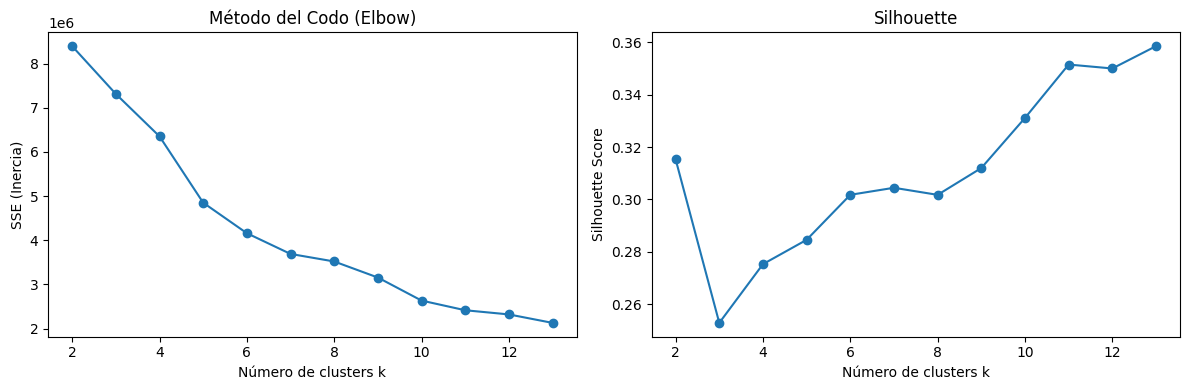

In [ ]:
# con tdqm

from tqdm import tqdm


# Asumiendo X_feat contiene las características preparadas (pos-PCA y binarias)
# y_mask de no-fraudes para ajuste (y == 0)

# Parámetros para K
K = range(2, 14)

sse = []
sil = []

# Ajustamos y transformamos solo con no-fraudes
X_norm = X_feat[y == 0]

# Recorrer K con barra de progreso
for k in tqdm(K, desc="Elbow y Silhouette progresivo"):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_norm)

    # SSE (inercia)
    sse.append(km.inertia_)

    # Silhouette (muestra aleatoria para acelerar si es necesario)
    labels = km.predict(X_norm)
    sil_score = silhouette_score(X_norm, labels, sample_size=100000, random_state=42)
    sil.append(sil_score)

# Graficar resultados
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(K, sse, '-o')
ax[0].set_xlabel('Número de clusters k')
ax[0].set_ylabel('SSE (Inercia)')
ax[0].set_title('Método del Codo (Elbow)')

ax[1].plot(K, sil, '-o')
ax[1].set_xlabel('Número de clusters k')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Silhouette')

plt.tight_layout()
plt.show()


#### Entrenar

In [ ]:
k_opt = 13  # elegimos ejemplo
km = KMeans(n_clusters=k_opt, random_state=42).fit(X_feat[y==0])
labels = km.predict(X_feat)


#### Anomalias x K-means

In [ ]:

dist = km.transform(X_feat).min(axis=1)
seuil = np.percentile(dist[y==0], 99)
anomaly_km = (dist > seuil).astype(int)

print("K‑Means:", classification_report(y, anomaly_km))


K‑Means:               precision    recall  f1-score   support

           0       1.00      0.99      0.99   2762196
           1       0.06      0.20      0.09      8213

    accuracy                           0.99   2770409
   macro avg       0.53      0.59      0.54   2770409
weighted avg       0.99      0.99      0.99   2770409



#### DBSCAN con silhouette

Reduccion a 10.000 parametros por saturacion de memoria en la colab

In [ ]:
from sklearn.utils import resample
from tqdm import tqdm

# Submuestreo para tuning (ajusta según tamaño disponible en memoria)
X_subset = resample(X_feat[y == 0], n_samples=10000, random_state=42)

# Búsqueda de hiperparámetros con tqdm
best, best_params = -1, {}
for eps in tqdm([0.3, 0.5, 0.7], desc="Buscando mejor eps"):
    for ms in [5, 10]:
        db = DBSCAN(eps=eps, min_samples=ms).fit(X_subset)
        labels = db.labels_
        if len(set(labels)) > 1:  # Al menos 2 clusters para calcular silhouette
            score = silhouette_score(X_subset, labels)
            if score > best:
                best = score
                best_params = {'eps': eps, 'min_samples': ms}

# Aplicar DBSCAN con los mejores parámetros a todo X_feat
db = DBSCAN(**best_params).fit(X_feat)
anomaly_db = (db.labels_ == -1).astype(int)


Buscando mejor eps: 100%|██████████| 3/3 [00:21<00:00,  7.04s/it]


#### Debido a que nuestro dtaset tiene bastantes registros la ejecucion con dbscan NO es posible por tema de recursos, asi que investigando encontramos el modelo HDBSCAN que es recomendado para datos masivos

#### Evaluacion

In [ ]:
from sklearn.metrics import classification_report
print("K‑Means:", classification_report(y, anomaly_km))
print("DBSCAN:", classification_report(y, anomaly_db))


NameError: name 'y' is not defined

In [ ]:
!pip install hdbscan

In [ ]:
# PASO 2: Importar librerías
from sklearn.ensemble import IsolationForest
import hdbscan
import time

# PASO 3: HDBSCAN
print("=== HDBSCAN ===")
t0 = time.time()

hdb = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=10)
hdb_labels = hdb.fit_predict(X_feat)

anomaly_hdb = (hdb_labels == -1).astype(int)
print(f"Tiempo: {time.time()-t0:.2f}s | Anomalías HDBSCAN: {np.sum(anomaly_hdb)}")

# PASO 4: Isolation Forest
print("\n=== Isolation Forest ===")
t0 = time.time()

iso = IsolationForest(n_estimators=100, contamination='auto', random_state=42, n_jobs=-1)
iso_labels = iso.fit_predict(X_feat)

anomaly_iso = (iso_labels == -1).astype(int)
print(f"Tiempo: {time.time()-t0:.2f}s | Anomalías Isolation Forest: {np.sum(anomaly_iso)}")


=== HDBSCAN ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Tiempo: 4059.95s | Anomalías HDBSCAN: 130279

=== Isolation Forest ===
Tiempo: 17.27s | Anomalías Isolation Forest: 710116


/tmp/ipython-input-34-2873474981.py:16: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=(vis_iso == -1), palette=["blue", "red"], s=8)


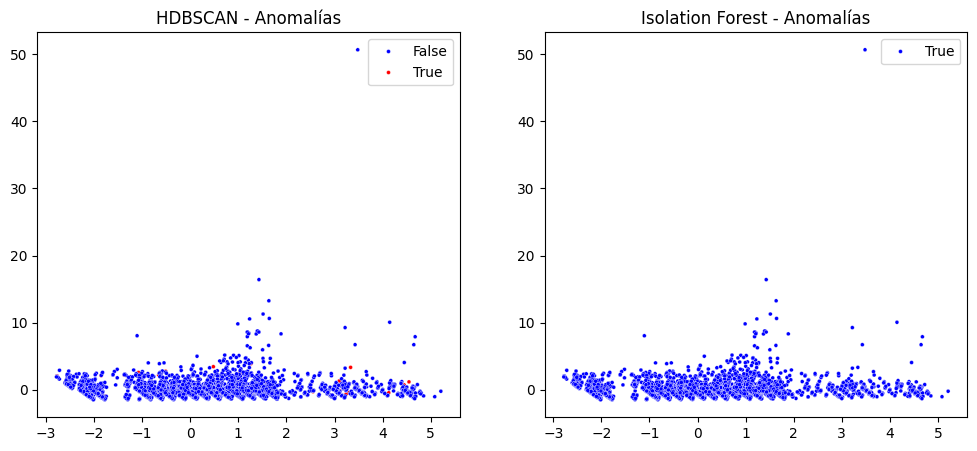

In [ ]:
# Reducimos para visualizar (10.000 puntos al azar)
from sklearn.utils import resample

X_vis = resample(X_feat, n_samples=10000, random_state=42)
vis_hdb = hdb.labels_[:len(X_vis)]
vis_iso = iso_labels[:len(X_vis)]

# Gráfico HDBSCAN
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=(vis_hdb == -1), palette=["blue", "red"], s=8)
plt.title("HDBSCAN - Anomalías")

# Gráfico Isolation Forest
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=(vis_iso == -1), palette=["blue", "red"], s=8)
plt.title("Isolation Forest - Anomalías")
plt.show()


-----------------------------

****Métodos para elegir el K****

Elbow

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Seleccionar variables para el clustering
X = df_final[["amount", "type_TRANSFER", "type_CASH_OUT"]].copy()

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Supongamos que X es tu dataset
wss = []
K = range(1, 11)  # Probar k de 1 a 10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wss.append(kmeans.inertia_)  # inertia_ es el WSS

# Graficar el codo
plt.plot(K, wss, 'bo-')
plt.xlabel('Número de clusters k')
plt.ylabel('WSS (Inertia)')
plt.title('Método del codo')
plt.show()

NameError: name 'X' is not defined

La técnica del codo (Elbow method) se usa para determinar el número óptimo de clusters en modelos como K-Means. La idea es calcular el WSS (Within-Cluster Sum of Squares) para distintos valores de k (número de clusters) y luego graficarlo. El punto donde la disminución de WSS comienza a ser menos pronunciada (forma un "codo") es el número óptimo de clusters.

En el método del codo, probamos distintos valores de
𝑘
k (número de clusters) y medimos el WSS (inercia). Cuanto más bajo el WSS, mejor agrupados están los puntos. Pero si aumentás mucho
𝑘
k, el WSS siempre va a bajar, aunque no necesariamente mejora el modelo.

Aquí el “codo” estaría alrededor de k = 3 porque después la mejora se reduce.

**Silhuette***


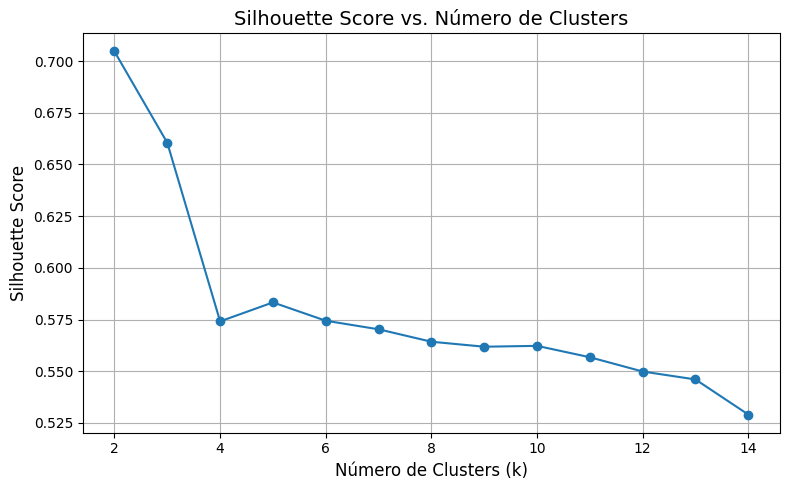

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Seleccionar variables para clustering
X = df_filtro[["amount", "type_TRANSFER", "type_CASH_OUT"]].copy()

# Eliminar valores nulos si los hubiera
X = X.dropna()

# Escalar las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calcular silhouette score para distintos k
sil = []
kmax = 14
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil_score = silhouette_score(X_scaled, labels, metric='euclidean')
    sil.append(sil_score)

# Graficar los resultados
plt.figure(figsize=(8, 5))
plt.plot(range(2, kmax+1), sil, marker='o', color="#1f78b4")
plt.title("Silhouette Score vs. Número de Clusters", fontsize=14)
plt.xlabel("Número de Clusters (k)", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


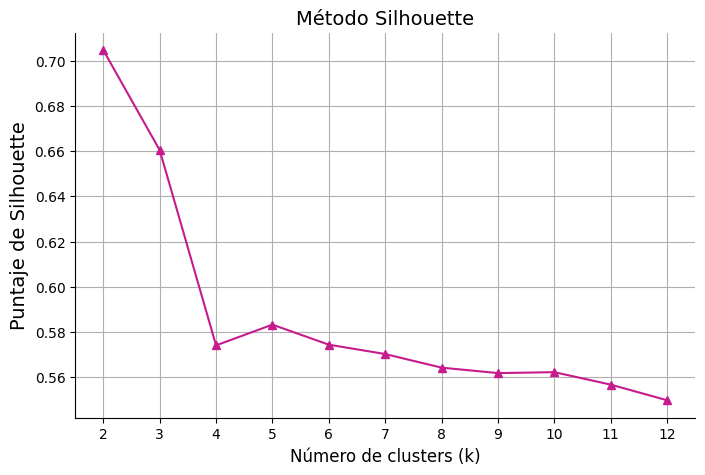

In [ ]:
# 1. Supongamos estas son tus variables de entrada
X = df_filtro[["amount", "type_TRANSFER", "type_CASH_OUT"]].copy()

# 2. Eliminar valores nulos si los hubiera
X = X.dropna()
# 2. Escalamos los datos (opcional pero recomendable para K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Probamos valores de k de 2 a 12
sil = []
K_range = range(2, 13)  # evitamos k=1 porque el Silhouette no se puede calcular con un solo grupo

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil.append(score)

# 4. Graficamos el puntaje de Silhouette
plt.figure(figsize=(8, 5))
plt.plot(K_range, sil, c="#c51b8d", marker='^', linestyle='-')
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title('Método Silhouette', size=14)
plt.xlabel('Número de clusters (k)', size=12)
plt.ylabel('Puntaje de Silhouette', size=14)
plt.xticks(K_range)
plt.grid(True)
plt.show()

Silhouette

In [ ]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 14

for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k).fit(X)
    labels = kmeans.labels_
    sil.append(silhouette_score(X, labels, metric='euclidean'))

In [ ]:
for i, score in enumerate(sil):
    print(f"k = {i+2}: Silhouette Score = {score}")

k = 2: Silhouette Score = 0.7046092271224564
k = 3: Silhouette Score = 0.6257031565400634
k = 4: Silhouette Score = 0.5825734482450169
k = 5: Silhouette Score = 0.5865121681034304
k = 6: Silhouette Score = 0.570669884517289
k = 7: Silhouette Score = 0.5783446511229935
k = 8: Silhouette Score = 0.5558992578137552
k = 9: Silhouette Score = 0.5593262107322863
k = 10: Silhouette Score = 0.547426824375326
k = 11: Silhouette Score = 0.5540769744201337
k = 12: Silhouette Score = 0.5355525535183149
k = 13: Silhouette Score = 0.5484825202782416
k = 14: Silhouette Score = 0.5399056146593869


Con el método de Silhouette el valor óptimo del número de clusters es cuando el coeficiente de silueta promedio alcanza su valor máximo. En este caso, el mayor valor se obtendría con un k=2
, veremos en detalle los grupos de clusters para ver si es correcta esta selección.

Para ello hacemos un análisis gráfico con los números de clusters que se corresponden con los picos del puntaje de silhouette.



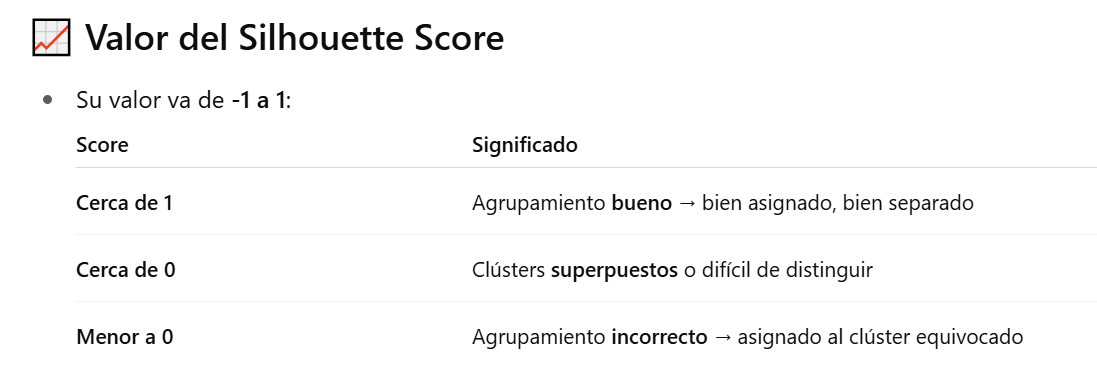

***SILHOUETTE***

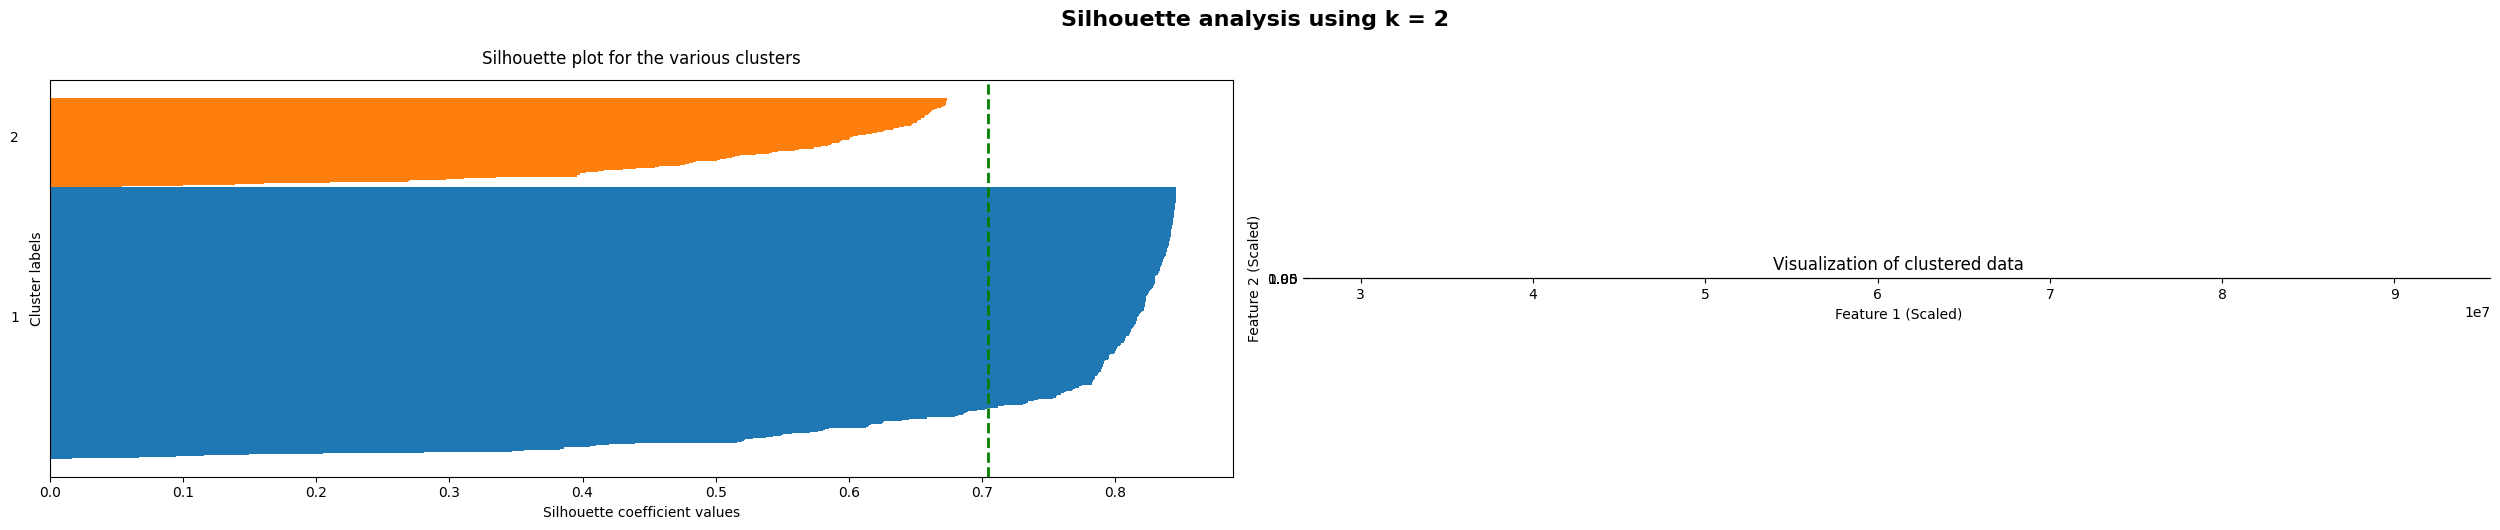

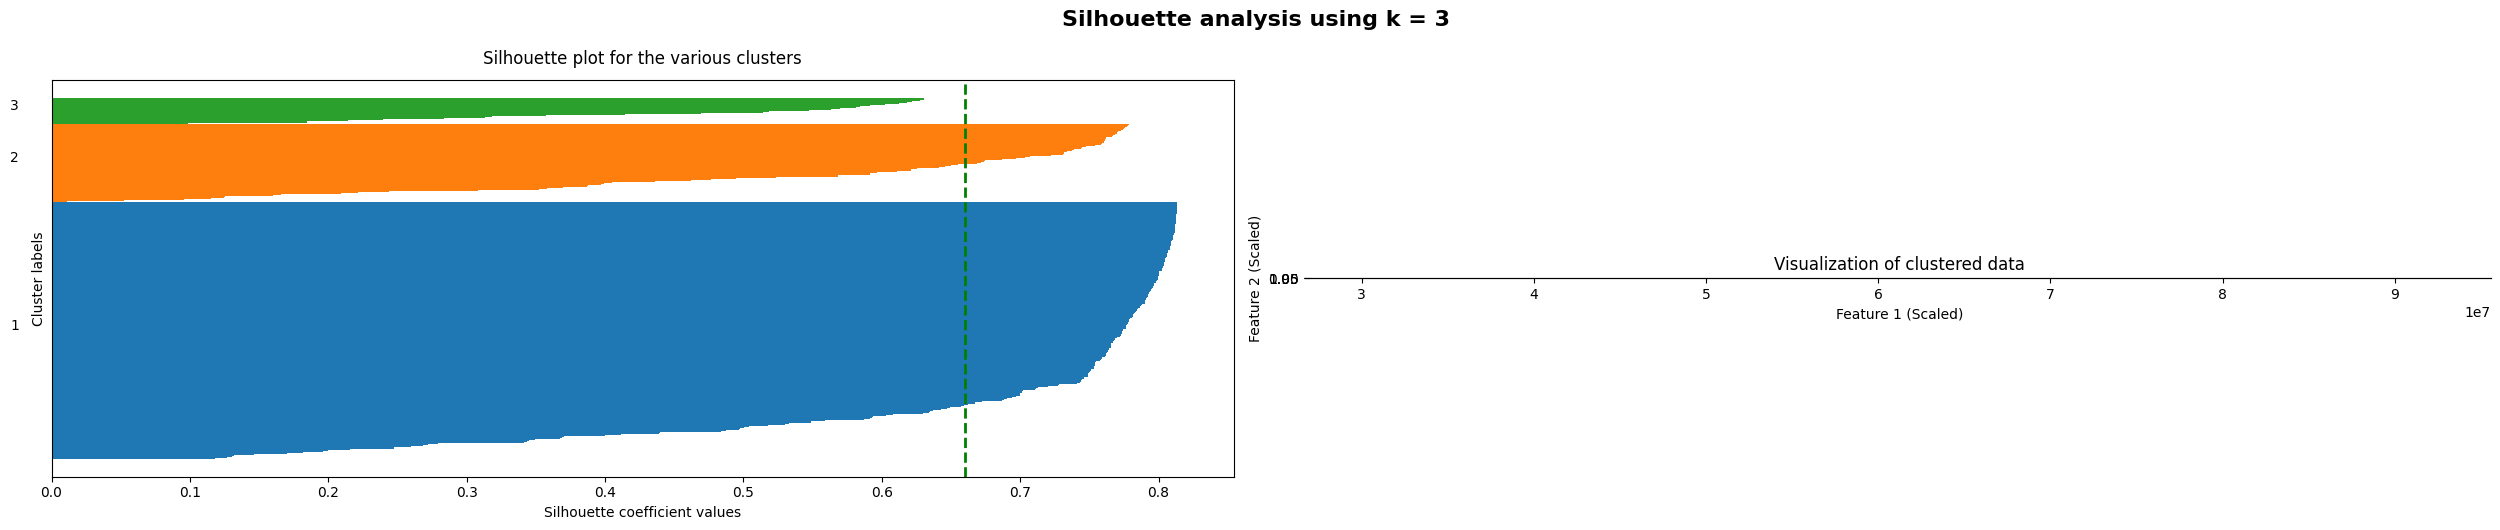

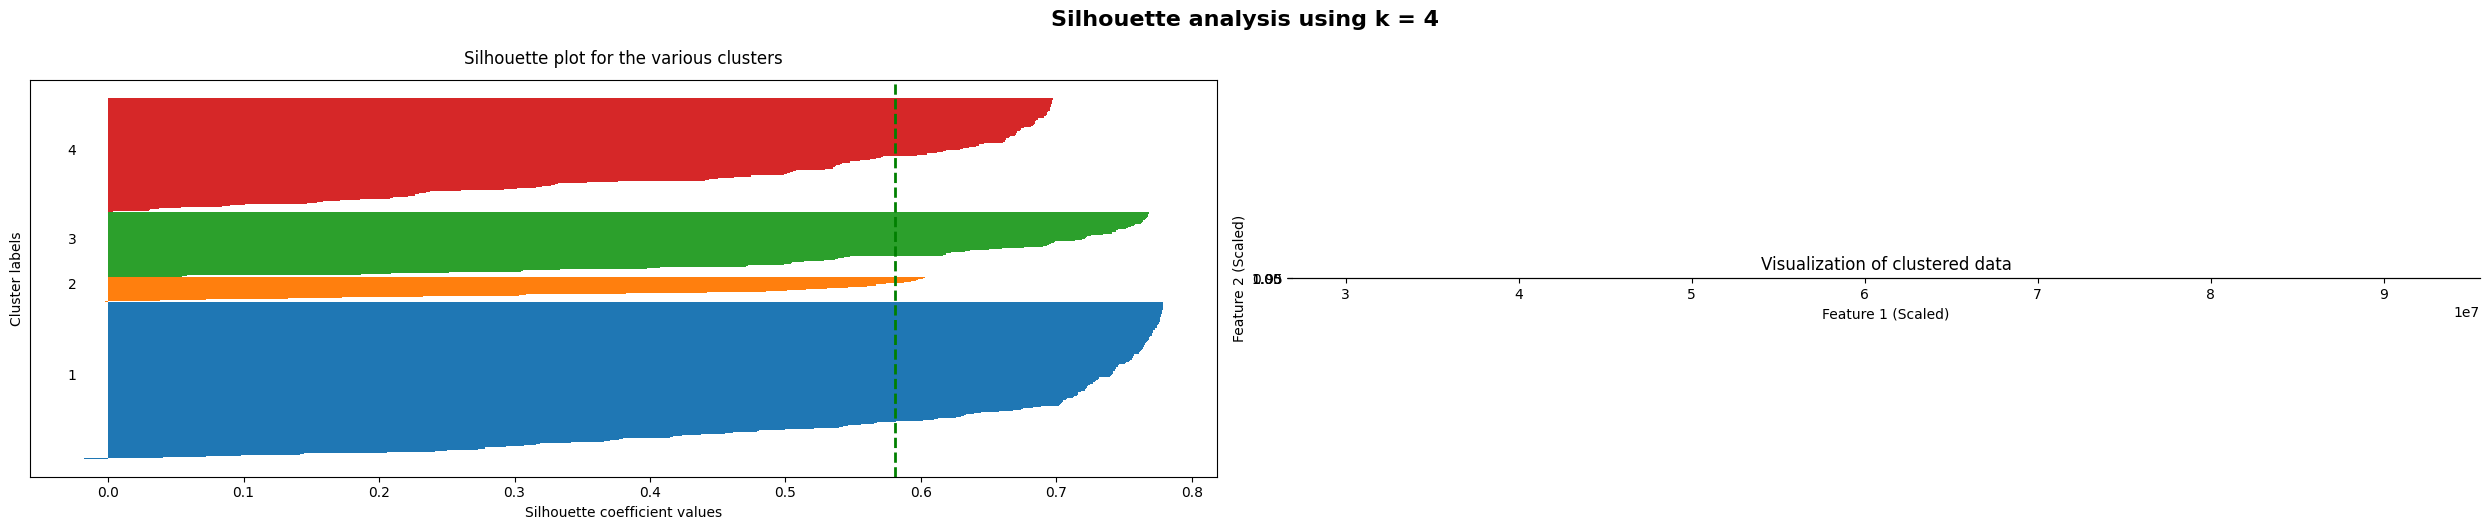

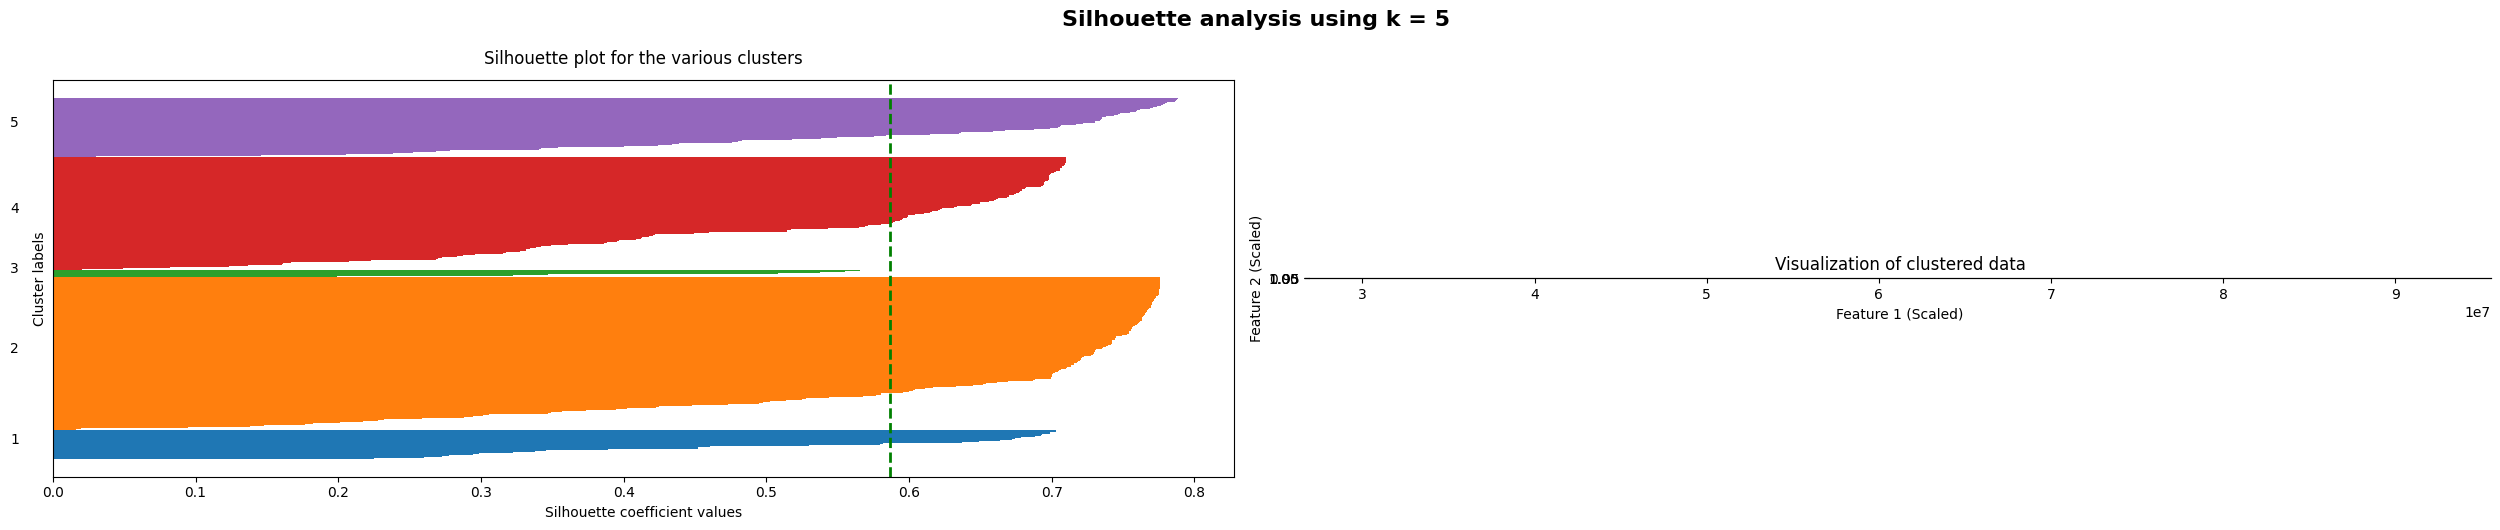

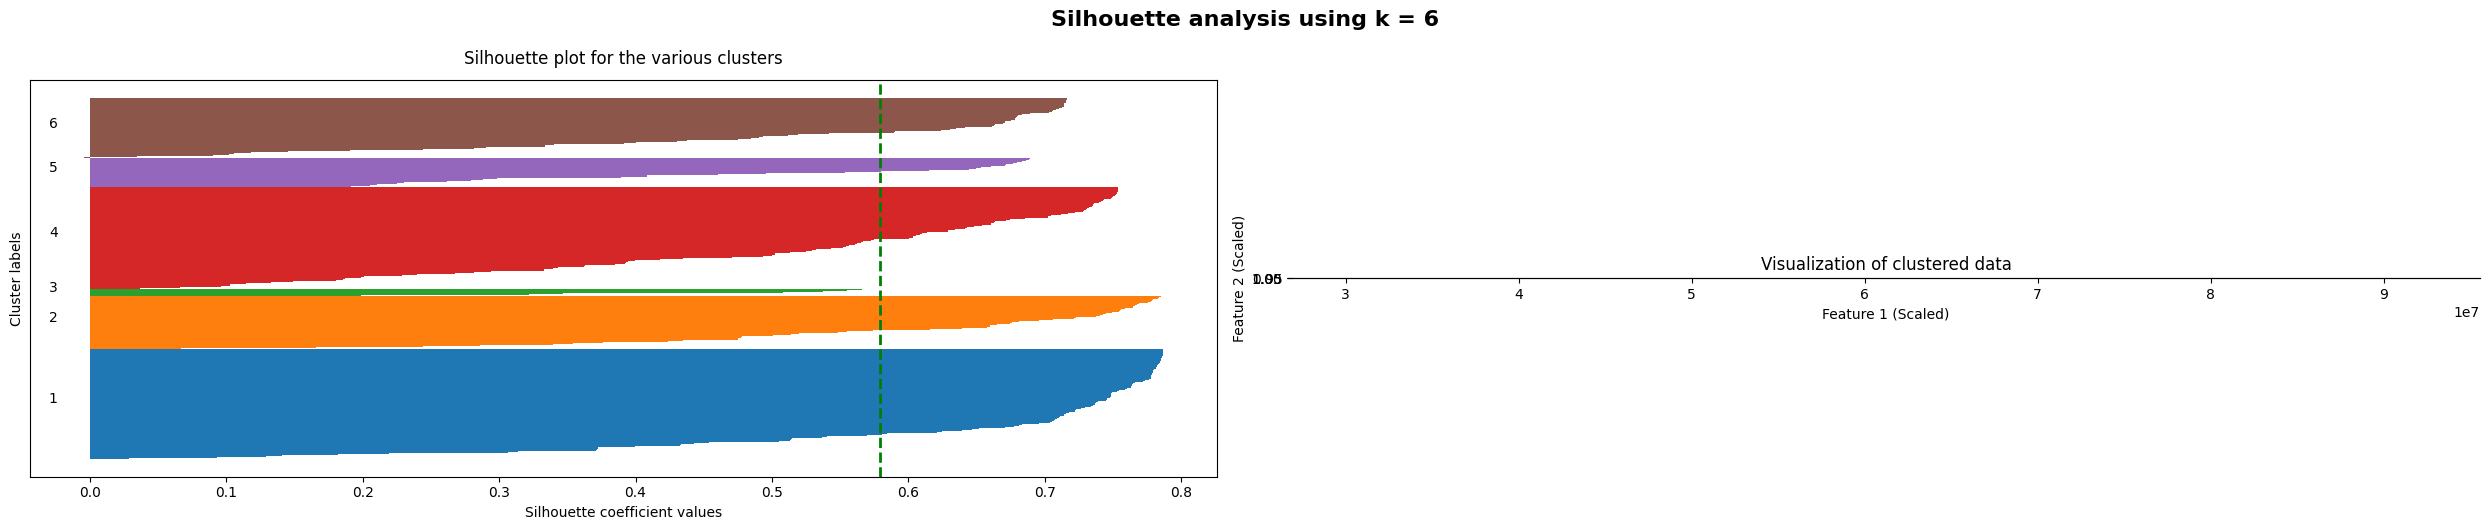

In [ ]:
import numpy as np # Import numpy

X_std = X # Utilice los datos escalados X
silhouette_vals = silhouette_samples(X_std, labels) # Esta línea no es necesaria aquí ya que se calculará dentro del bucle
avg_score = np.mean(silhouette_vals) # Esta línea no es necesaria aquí

# Se ajustó la lista_k para comenzar desde 2 ya que la puntuación de silueta no está definida para k=1
lista_k = [2, 3, 4, 5, 6]
# VER SI ES CORRECTO O SI SE PUEDE DISMINUIR EN MENOS VALORES

for i, k in enumerate(lista_k):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    fig.set_size_inches(25, 5)

    kmS = KMeans(n_clusters=k, random_state=42, n_init=10) # Se agregaron random_state y n_init
    labels = kmS.fit_predict(X_std)
    centroids = kmS.cluster_centers_

    silhouette_vals = silhouette_samples(X_std, labels)

    y_ticks = []
    y_lower, y_upper = 0, 0
    for j, cluster in enumerate(np.unique(labels)): #Se cambió la variable de bucle a j para evitar conflictos con el bucle externo
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(j + 1)) # Se cambió la variable de bucle a j
        y_lower += len(cluster_silhouette_vals)


    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);

    # Suponiendo que el gráfico de dispersión es para los dos primeros componentes de los datos escalados
    ax2.scatter(X_std.iloc[:, 0], X_std.iloc[:, 1], c=labels) # Se modificó para utilizar .iloc para la indexación de DataFrame
    ax2.set_xlabel('Feature 1 (Scaled)') # Etiqueta cambiada
    ax2.set_ylabel('Feature 2 (Scaled)') # Etiqueta cambiada
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);





El valor óptimo de k obtenido con el método de Silhouette es k = 2 cumple. El mismo valor coincide con el obtenido en el método del codo.

 👩🏽‍💻 Aprendizaje No Supervisado 📣

****Modelo K-Means  y DBSCAN ****


KMeans

/tmp/ipython-input-19-136990346.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cluster"] = labels


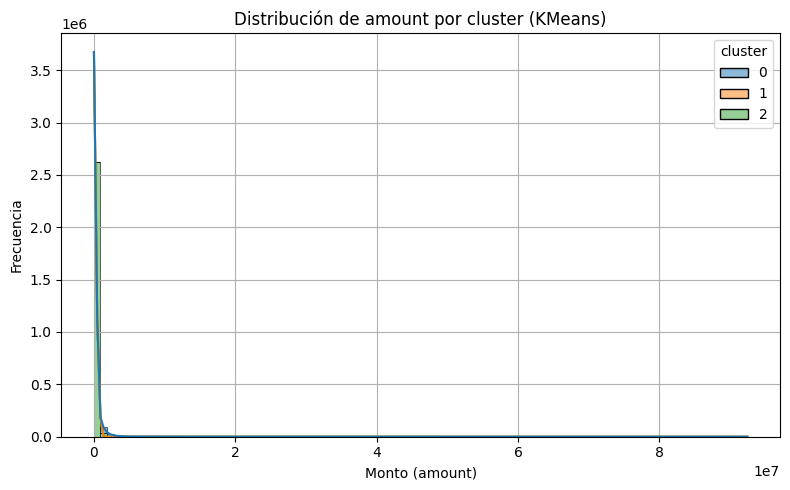

cluster
2    2666230
0      96424
1       7755
Name: count, dtype: int64


In [ ]:
# Con df_final
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


# Seleccionar solo la columna 'amount'
data = df_final[["amount"]]

# Escalar la variable
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Elegir número de clusters (por ejemplo, 4)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(data_scaled)

# Agregar etiquetas al DataFrame
data["cluster"] = labels

# Visualizar los resultados
plt.figure(figsize=(8, 5))
sns.histplot(data=data, x="amount", hue="cluster", bins=100, kde=True, palette="tab10", multiple="stack")
plt.title("Distribución de amount por cluster (KMeans)")
plt.xlabel("Monto (amount)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

# Ver la cantidad de puntos por cluster
print(data["cluster"].value_counts())

/tmp/ipython-input-21-272695903.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cluster"] = labels


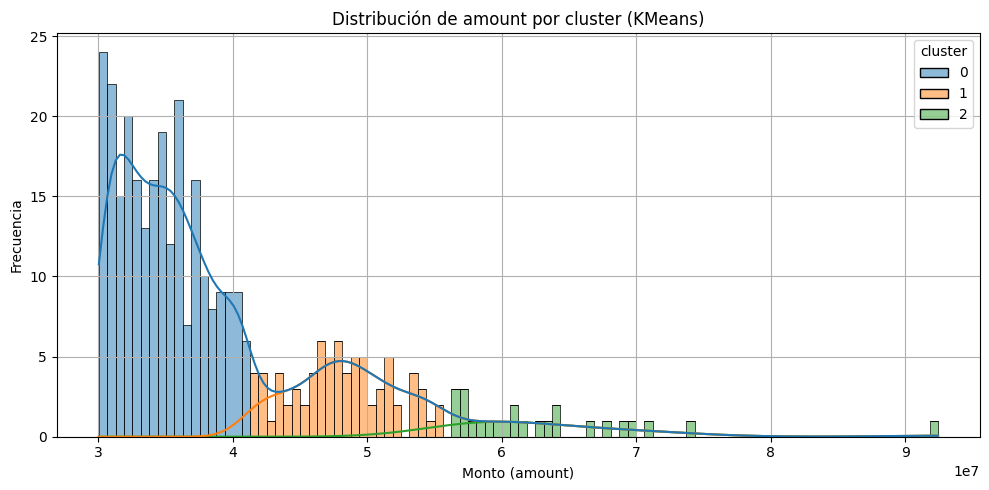

cluster
0    252
1     77
2     25
Name: count, dtype: int64


In [ ]:
# Con df_filtro
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


# Seleccionar solo la columna 'amount'
data = df_filtro[["amount"]]

# Escalar la variable
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Elegir número de clusters (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(data_scaled)

# Agregar etiquetas al DataFrame
data["cluster"] = labels

# Visualizar los resultados
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x="amount", hue="cluster", bins=100, kde=True, palette="tab10", multiple="stack")
plt.title("Distribución de amount por cluster (KMeans)")
plt.xlabel("Monto (amount)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

# Ver la cantidad de puntos por cluster
print(data["cluster"].value_counts())


#### MiniBatchKMeans

#### Ideal para trabajar con grandes volúmenes de datos.
#### Es una versión optimizada de K-Means diseñada para trabajar de manera eficiente con datasets grandes. Utiliza pequeños "mini-batches" de datos  aleatorios para actualizar los centroides.

/tmp/ipython-input-22-3440109834.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amount_sample["cluster"] = labels


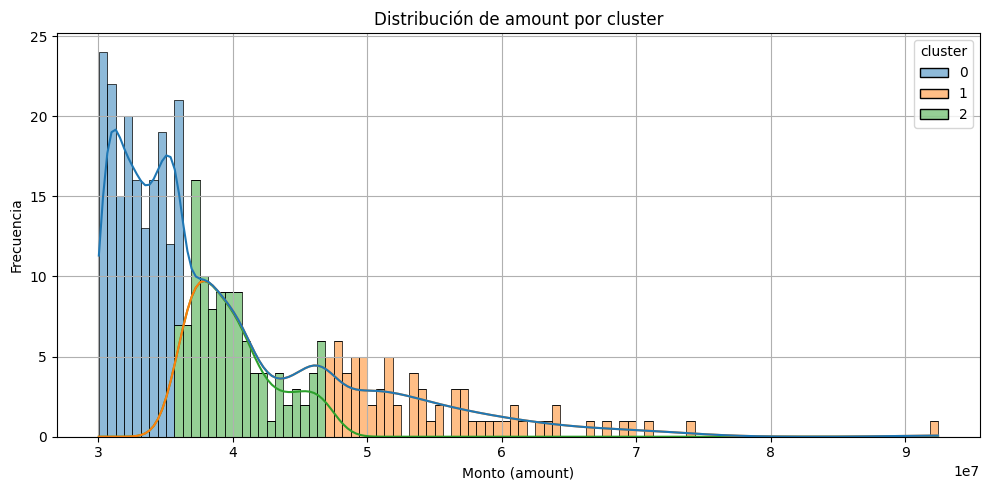

cluster
0    171
2    111
1     72
Name: count, dtype: int64


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns


# Tomar una muestra aleatoria
amount_sample = df_filtro[["amount"]]

# Escalar los datos
scaler = StandardScaler()
amount_scaled = scaler.fit_transform(amount_sample)

# Aplicar MiniBatchKMeans con 3 clusters (k=3)
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42, batch_size=1000)
labels = kmeans.fit_predict(amount_scaled)

# Agregar etiquetas al DataFrame
amount_sample["cluster"] = labels

# Visualizar los resultados
plt.figure(figsize=(10, 5))
sns.histplot(data=amount_sample, x="amount", hue="cluster", bins=100, palette="tab10", kde=True, multiple="stack")
plt.title("Distribución de amount por cluster")
plt.xlabel("Monto (amount)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

# Ver cantidad de elementos por cluster
print(amount_sample["cluster"].value_counts())


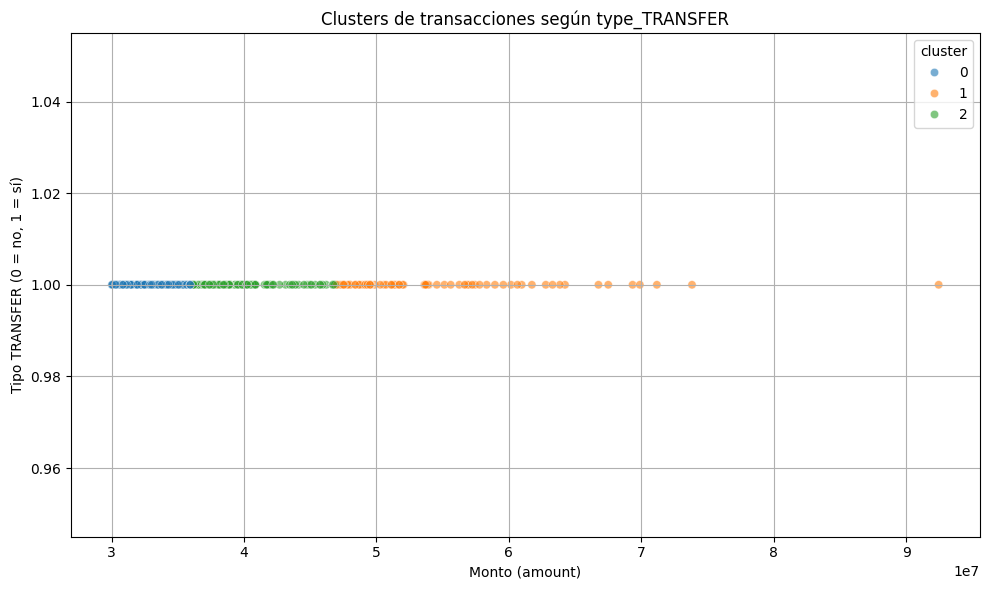

cluster
0    171
2    111
1     72
Name: count, dtype: int64


In [ ]:
# Por 'amount' y 'type_TRANSFER'
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar variables
amount_sample = df_filtro[['amount',"type_TRANSFER"]].copy()

# Escalar los datos
scaler = StandardScaler()
amount_scaled = scaler.fit_transform(amount_sample)

# Aplicar MiniBatchKMeans (k=3)
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42, batch_size=1000)
labels = kmeans.fit_predict(amount_scaled)

# Agregar etiquetas al DataFrame
amount_sample["cluster"] = labels

# Visualización 2D (amount vs. type_TRANSFER)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=amount_sample, x="amount", y="type_TRANSFER",
    hue="cluster", palette="tab10", alpha=0.6
)
plt.title("Clusters de transacciones según type_TRANSFER")
plt.xlabel("Monto (amount)")
plt.ylabel("Tipo TRANSFER (0 = no, 1 = sí)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Ver cantidad de elementos por cluster
print(amount_sample["cluster"].value_counts())


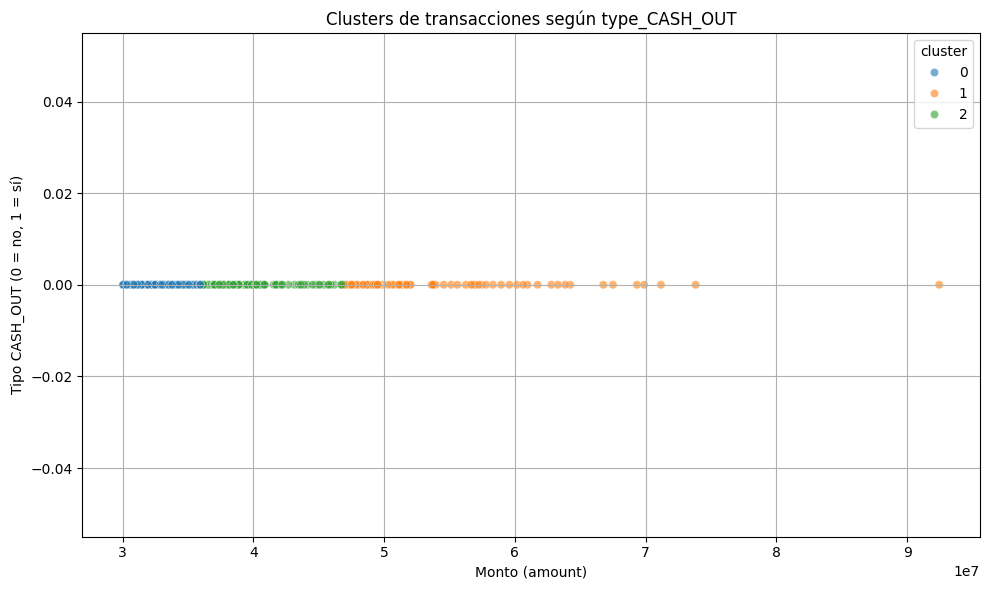

cluster
0    171
2    111
1     72
Name: count, dtype: int64


In [ ]:
# Por 'amount' y 'type_CASH_OUT'
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar variables
amount_sample = df_filtro[['amount',"type_CASH_OUT"]].copy()

# Escalar los datos
scaler = StandardScaler()
amount_scaled = scaler.fit_transform(amount_sample)

# Aplicar MiniBatchKMeans (k=3)
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42, batch_size=1000)
labels = kmeans.fit_predict(amount_scaled)

# Agregar etiquetas al DataFrame
amount_sample["cluster"] = labels

# Visualización 2D (amount vs. type_CASH_OUT)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=amount_sample, x="amount", y="type_CASH_OUT",
    hue="cluster", palette="tab10", alpha=0.6
)
plt.title("Clusters de transacciones según type_CASH_OUT")
plt.xlabel("Monto (amount)")
plt.ylabel("Tipo CASH_OUT (0 = no, 1 = sí)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Ver cantidad de elementos por cluster
print(amount_sample["cluster"].value_counts())


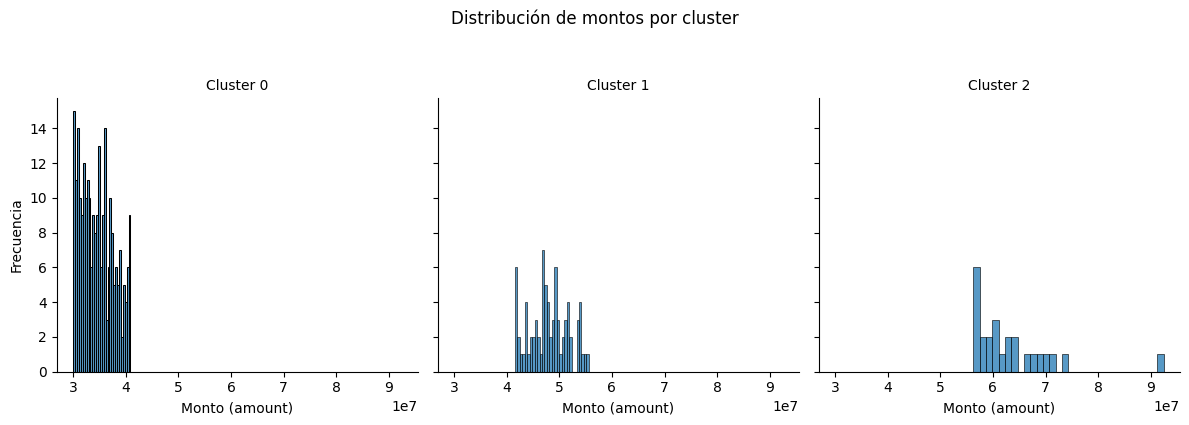

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Seleccionar variables para clustering
X = df_filtro[["amount"]].copy()
X = X.dropna()

# 2. Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Aplicar KMeans con 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# 4. Guardar resultados en el DataFrame original
df_filtro = df_filtro.loc[X.index].copy()  # alineamos los índices por si hubo .dropna()
df_filtro["cluster"] = labels

# 5. Visualizar la distribución de 'amount' por cluster
g = sns.FacetGrid(df_filtro, col='cluster', col_wrap=3, height=4)
g.map_dataframe(sns.histplot, x='amount', bins=30, color='#1f77b4')
g.set_axis_labels('Monto (amount)', 'Frecuencia')
g.set_titles('Cluster {col_name}')
g.fig.suptitle('Distribución de montos por cluster', y=1.05)
plt.tight_layout()
plt.show()


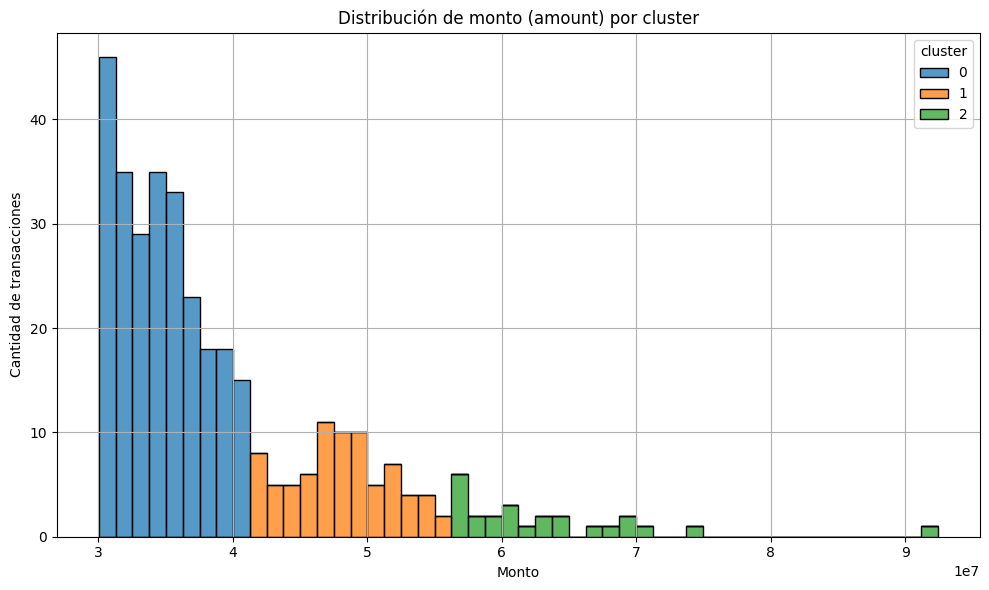

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=df_filtro, x='amount', hue='cluster', bins=50, multiple='stack', palette='tab10')
plt.title('Distribución de monto (amount) por cluster')
plt.xlabel('Monto')
plt.ylabel('Cantidad de transacciones')
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-36-3055460262.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtro, x='cluster', y='amount', palette='tab10')


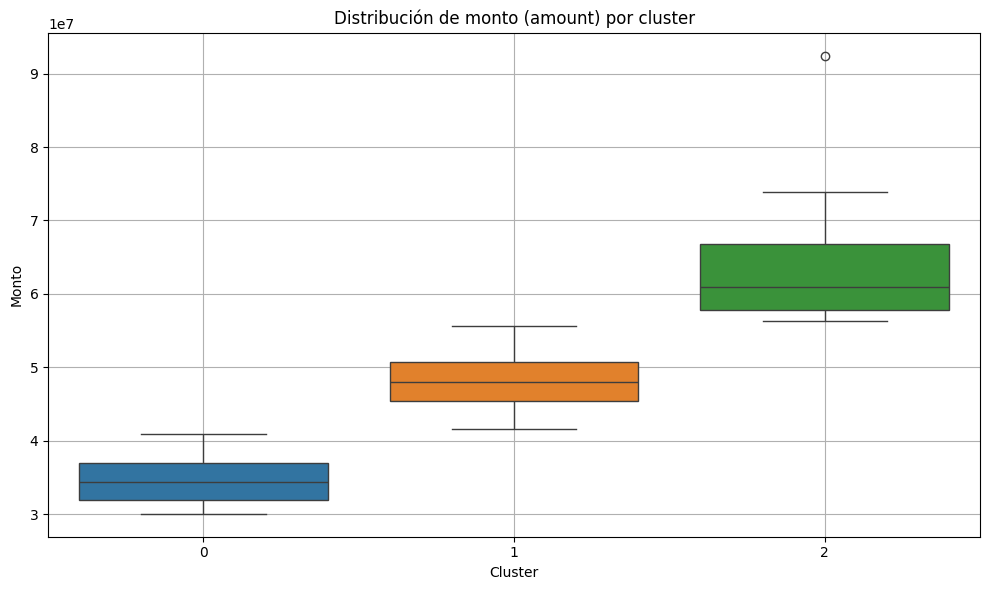

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtro, x='cluster', y='amount', palette='tab10')
plt.title('Distribución de monto (amount) por cluster')
plt.xlabel('Cluster')
plt.ylabel('Monto')
plt.grid(True)
plt.tight_layout()
plt.show()


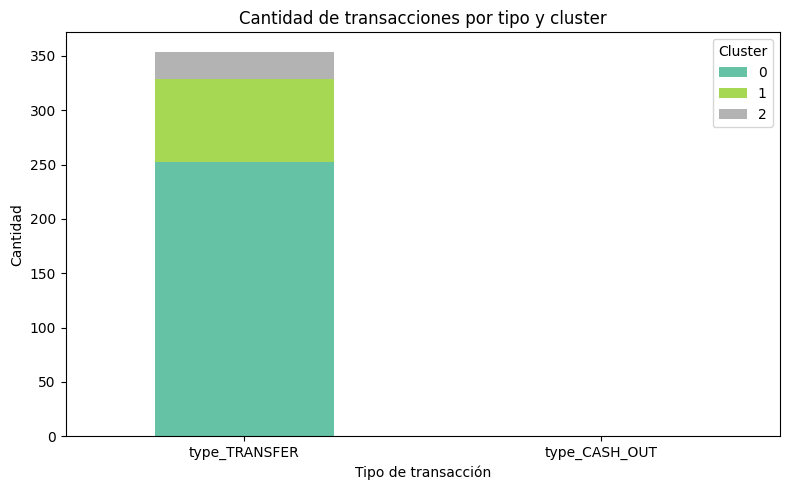

In [ ]:
import matplotlib.pyplot as plt

# Agrupar por cluster y tipo de transacción
tipo_por_cluster = df_filtro.groupby('cluster')[['type_TRANSFER', 'type_CASH_OUT']].sum().T

# Graficar
tipo_por_cluster.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='Set2')
plt.title('Cantidad de transacciones por tipo y cluster')
plt.xlabel('Tipo de transacción')
plt.ylabel('Cantidad')
plt.legend(title='Cluster')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Bien sabemos que las  diferencias entre DBSCAN y K-Means son fundamentales, ya que son algoritías de clustering (agrupamiento) pero con enfoques muy distintos.
K-Measn , agrupa puntos alrededor de centroides, mientras que
DBSCAN ,agrupa puntos densamente conectados.

Por la caracteristica de nuestro data set vamos a utilizar el análisis de DBSCAN.


DBSCAN
Scikit-learn tiene una implementación para DBSCAN.


#### DBSCAN



/tmp/ipython-input-34-3946845484.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cluster"] = labels


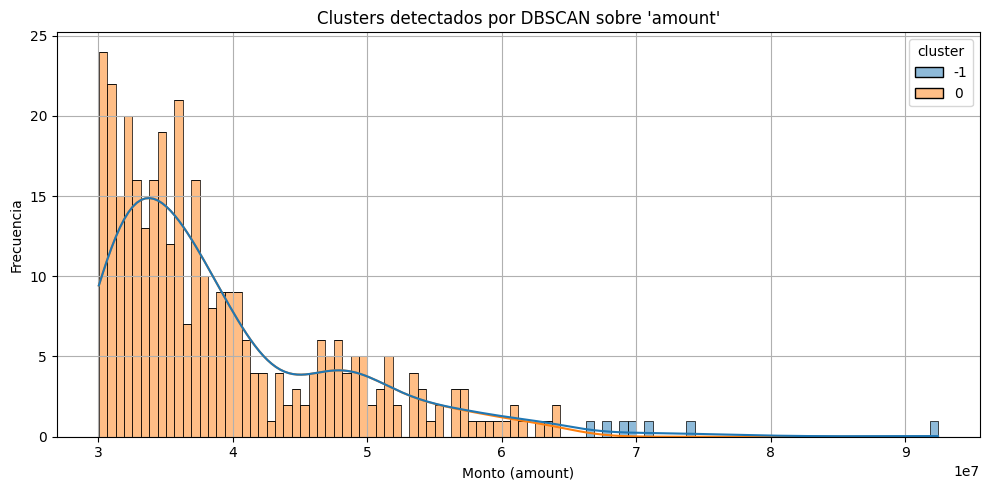

cluster
 0    347
-1      7
Name: count, dtype: int64


In [ ]:
# Para 'amount'
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que ya cargaste tu dataset como df_final o df_filtro
# Seleccionamos la columna 'amount' (y una muestra si es muy grande)
data = df_filtro[["amount"]]

# Escalar los datos (DBSCAN es sensible a la escala)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Aplicar DBSCAN
# Puedes ajustar eps y min_samples según el comportamiento de tus datos
dbscan = DBSCAN(eps=0.3, min_samples=10)
labels = dbscan.fit_predict(data_scaled)

# Agregar las etiquetas de cluster al DataFrame
data["cluster"] = labels

# Visualizar: histograma de 'amount' coloreado por cluster
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x="amount", hue="cluster", bins=100, kde=True, palette="tab10", multiple="stack")
plt.title("Clusters detectados por DBSCAN sobre 'amount'")
plt.xlabel("Monto (amount)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

# Ver la cantidad de puntos por cluster (incluyendo -1 = outliers)
print(data["cluster"].value_counts())


In [ ]:
# Para 'type_CASH_OUT'
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Seleccionar la variable
data = df_filtro[["type_CASH_OUT"]].copy()

# Escalar (opcional pero consistente)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Aplicar DBSCAN
db = DBSCAN(eps=0.5, min_samples=5)
labels = db.fit_predict(data_scaled)

# Agregar etiquetas
data["cluster"] = labels
print(data["cluster"].value_counts())


cluster
0    354
Name: count, dtype: int64


#### Aplicar DBSCAN sobre la variable type_CASH_OUT no es útil directamente, porque es una variable categórica binaria (0 o 1). DBSCAN está diseñado para encontrar clusters en espacios continuos, densos y multivariables.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Seleccionar la variable
data = df_filtro[["type_TRANSFER"]].copy()

# Escalar (opcional pero consistente)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Aplicar DBSCAN
db = DBSCAN(eps=0.5, min_samples=5)
labels = db.fit_predict(data_scaled)

# Agregar etiquetas
data["cluster"] = labels
print(data["cluster"].value_counts())


cluster
0    354
Name: count, dtype: int64


#### Aplicar DBSCAN sobre la variable type_TRANSFER no es útil directamente, porque es una variable categórica binaria (0 o 1). DBSCAN está diseñado para encontrar clusters en espacios continuos, densos y multivariables.

Redes Neuronales

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  #

In [ ]:
# Paso 1: Definir X e y
X = df_filtro[["amount", "type_TRANSFER", "type_CASH_OUT"]].copy()
y = df_filtro["isFraud"]

# Paso 2: Aplicar SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

# Paso 3: División de datos balanceados
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)

# Paso 4: Normalización solo con datos de entrenamiento
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Paso 5: Red neuronal
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Recall'])

# Paso 6: Entrenamiento
model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test))


ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [ ]:
# Paso 1: Definir X e y
X = df_filtro[["amount", "type_TRANSFER", "type_CASH_OUT"]].copy()
y = df_filtro["isFraud"]

# Paso 2: Aplicar SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

# Paso 3: División de datos balanceados
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)

# Paso 4: Normalización solo con datos de entrenamiento
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Paso 5: Red neuronal
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Recall'])

# Paso 6: Entrenamiento
model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_

SyntaxError: incomplete input (ipython-input-24-1481281357.py, line 26)

In [ ]:
# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balanceo
smote = SMOTE(random_state=42)
X = df_filtro[["amount", "type_TRANSFER", "type_CASH_OUT"]].copy()
y = df_filtro["isFraud"]
X_bal, y_bal = smote.fit_resample(X, y)

# División
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42)

# Red neuronal simple
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Salida binaria

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Recall'])

model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test))

ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead